# London bike sharing dataset
The dataset we'll be analyzing is the "Bike Share" data. It shows the amount of bikes rented every hour in London and it's related parameters.

### By LSTM Model
#### Aim: 
- Our goal is to predict the number of future bike shares given the historical data of London bike shares

#### Dataset link
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset?select=london_merged.csv

Here are the steps we did:

- Data
- Data preprocessing
- Exploratory Data Analysis
- Splitting the data into Train, Test
- Building Model
- Predicting Demand
- Evaluation


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Import the dataset
df= pd.read_csv('london_merged.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


- timestamp - timestamp field for grouping the data
- cnt - the count of a new bike shares
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- hum - humidity in percentage
- wind_speed - wind speed in km/h
- weather_code - category of the weather
- is_holiday - boolean field - 1 holiday / 0 non holiday
- is_weekend - boolean field - 1 if the day is weekend
season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

## Data preprocessing

In [3]:
# lets see the info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
# One thing I did notice is that the timestamp isn't of the type "DateTime". 
# We're gonna change this and also set the timestamp as index.

df['timestamp']= pd.to_datetime(df['timestamp'])
df= df.set_index('timestamp')
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
# Checking any missing values
df.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [6]:
#We'll be creating these features since they could come in handy whilest training some future models.
df['hour']= df.index.hour
df['day_of_week']= df.index.dayofweek
df['day_of_month']= df.index.day
df['month']=df.index.month
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


### Exploratory Data Analysis

Text(0, 0.5, 'Amount of bike shares')

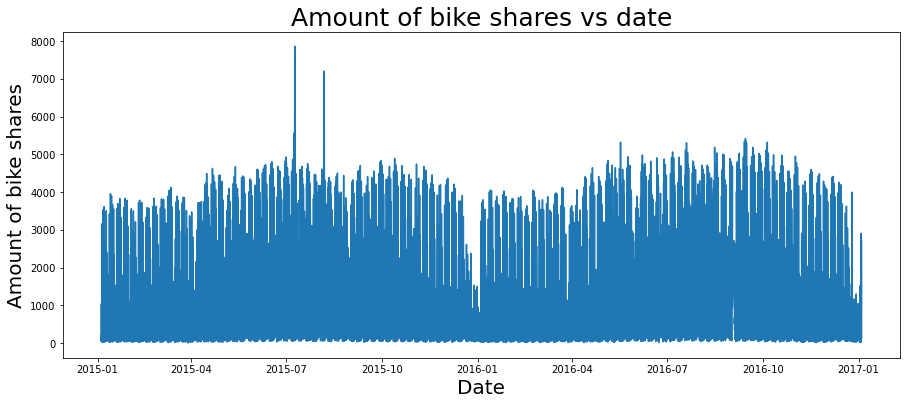

In [7]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df.index,y='cnt',data=df)
plt.title("Amount of bike shares vs date", fontsize=25)
plt.xlabel("Date", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

In [8]:
# Resample timeseries, for plotting timeseries month frequency
df1=df.resample('M').sum()

Text(0, 0.5, 'Amount of bike shares')

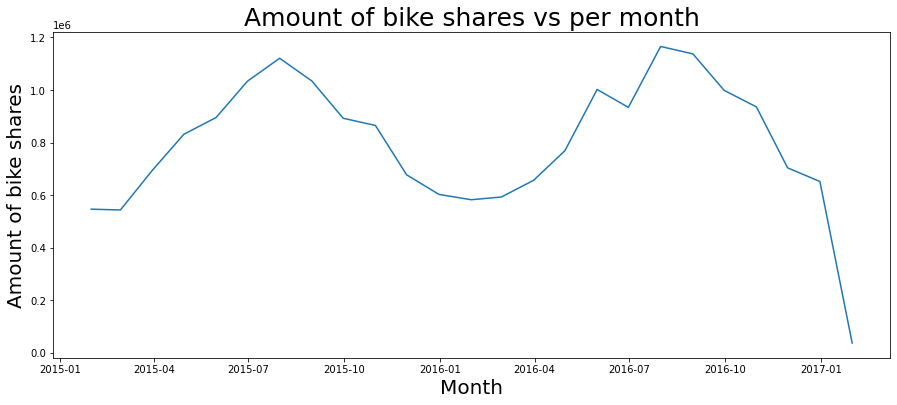

In [9]:
# Let’s have a look at the same data on a monthly basis:
plt.figure(figsize=(15,6))
sns.lineplot(x=df1.index,y='cnt',data=df1)
plt.title("Amount of bike shares vs per month", fontsize=25)
plt.xlabel("Month", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

**Our data seems to have a strong seasonality component. Summer months are good for business**

Text(0, 0.5, 'Amount of bike shares')

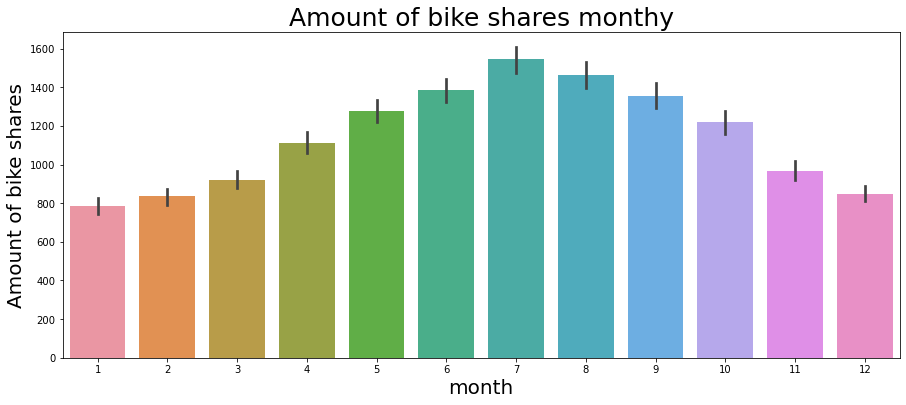

In [10]:
plt.figure(figsize=(15,6))
sns.barplot(x='month',y='cnt', data=df)
plt.title("Amount of bike shares monthy", fontsize=25)
plt.xlabel("month", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

**In month from May to October maximum bike counts. As expected, in summer, bike shares is increasing**

Text(0, 0.5, 'Amount of bike shares')

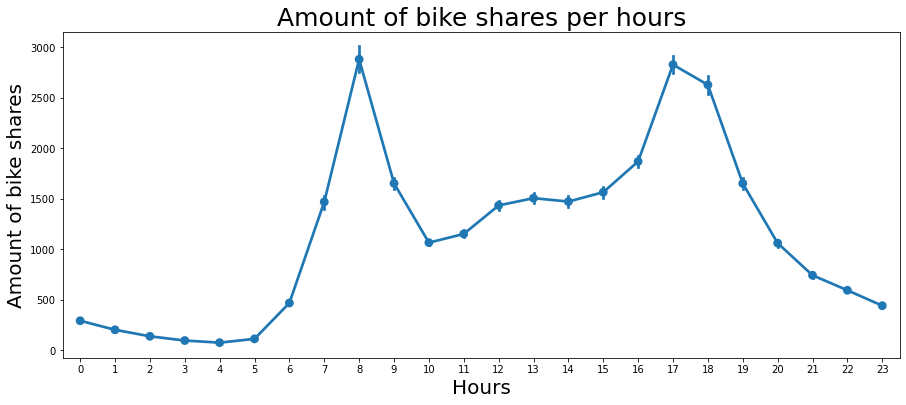

In [11]:
# How about the bike shares by the hour:
plt.figure(figsize=(15,6))
sns.pointplot(x='hour',y='cnt',data=df)
plt.title("Amount of bike shares per hours", fontsize=25)
plt.xlabel("Hours", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

Text(0, 0.5, 'Amount of bike shares')

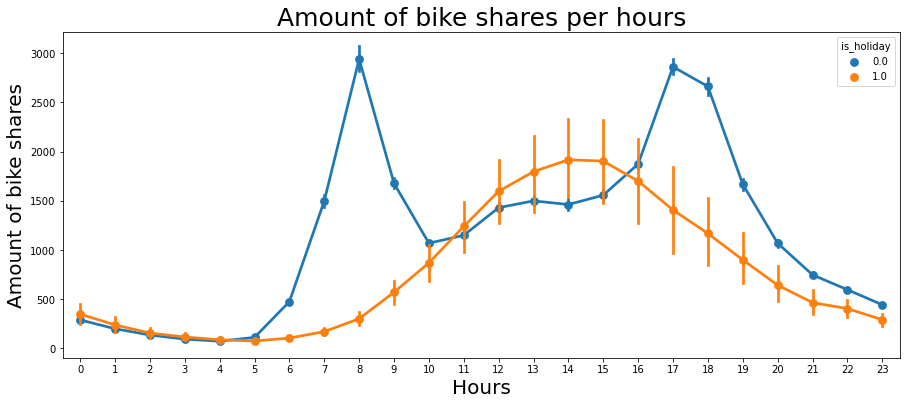

In [12]:
plt.figure(figsize=(15,6))
sns.pointplot(x='hour',y='cnt',hue='is_holiday', data=df)
plt.title("Amount of bike shares per hours", fontsize=25)
plt.xlabel("Hours", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

Text(0, 0.5, 'Amount of bike shares')

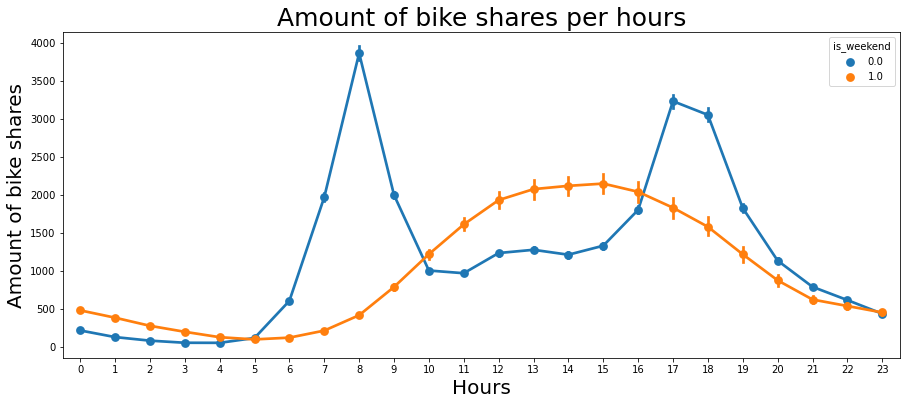

In [13]:
plt.figure(figsize=(15,6))
sns.pointplot(x='hour',y='cnt',hue='is_weekend', data=df)
plt.title("Amount of bike shares per hours", fontsize=25)
plt.xlabel("Hours", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

Text(0, 0.5, 'Amount of bike shares')

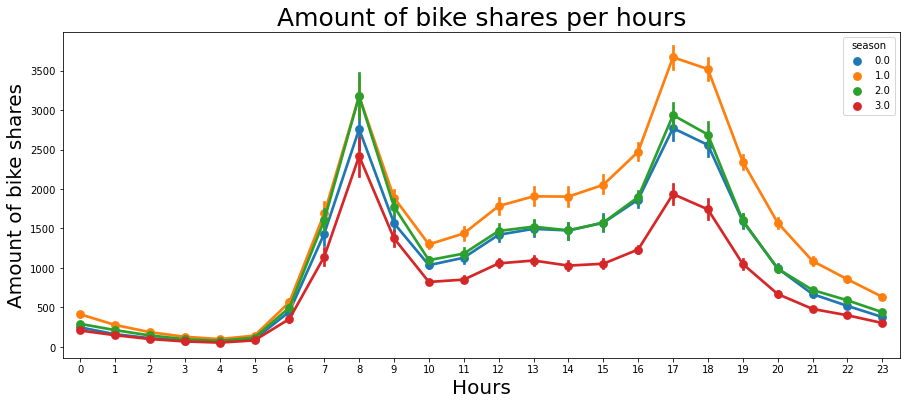

In [14]:
plt.figure(figsize=(15,6))
sns.pointplot(x='hour',y='cnt',hue='season', data=df)
plt.title("Amount of bike shares per hours", fontsize=25)
plt.xlabel("Hours", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

**The hours with most bike shares differ significantly based on a weekend or not days. Workdays contain two large spikes during the morning and late afternoon hours (people pretend to work in between). On weekends early to late afternoon hours seem to be the busiest.**

Text(0, 0.5, 'Amount of bike shares')

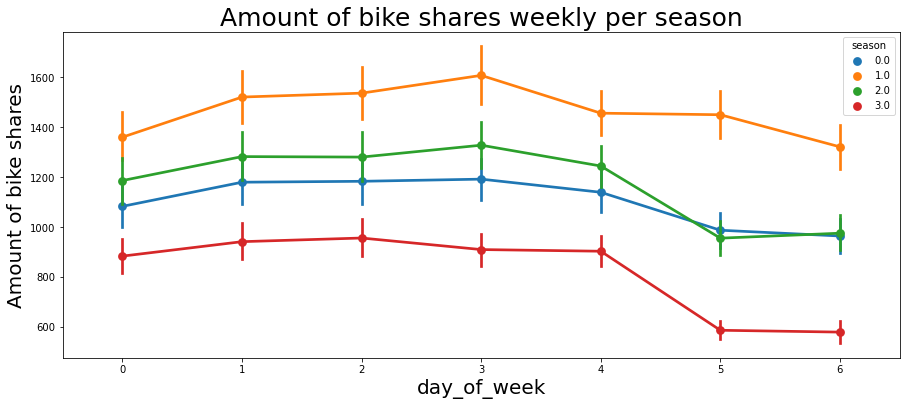

In [15]:
plt.figure(figsize=(15,6))
sns.pointplot(x='day_of_week',y='cnt',hue='season', data=df)
plt.title("Amount of bike shares weekly per season", fontsize=25)
plt.xlabel("day_of_week", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

Text(0, 0.5, 'Amount of bike shares')

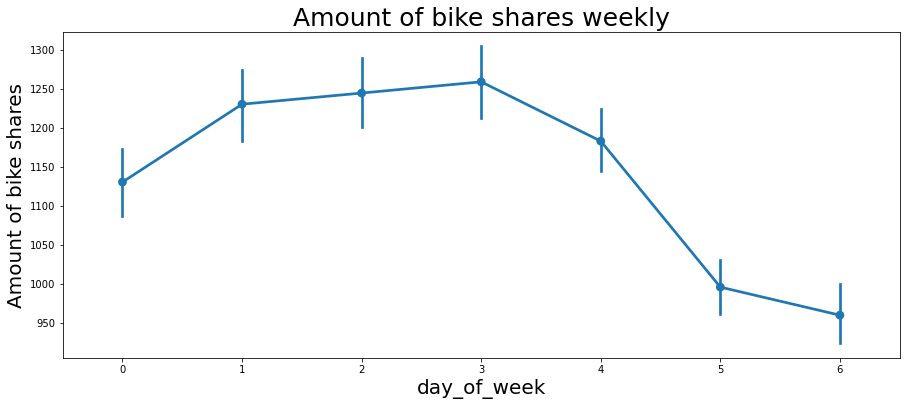

In [16]:
plt.figure(figsize=(15,6))
sns.pointplot(x='day_of_week',y='cnt', data=df)
plt.title("Amount of bike shares weekly", fontsize=25)
plt.xlabel("day_of_week", fontsize=20)
plt.ylabel('Amount of bike shares', fontsize=20)

**Looking at the data by day of the week shows a much higher count on the number of bike shares on monday to friday**

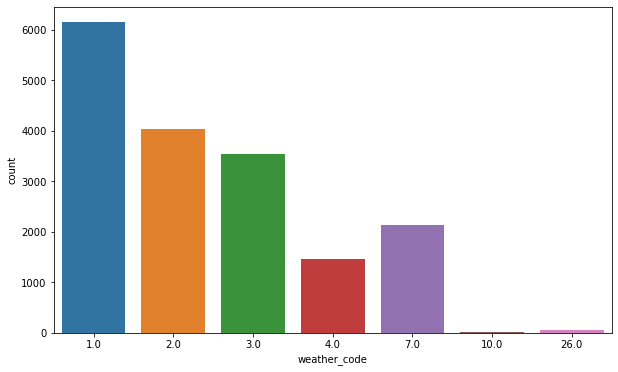

In [17]:
# with countplot

plt.figure(figsize=(10,6))
sns.countplot(x = "weather_code", data = df);

<Figure size 432x288 with 0 Axes>

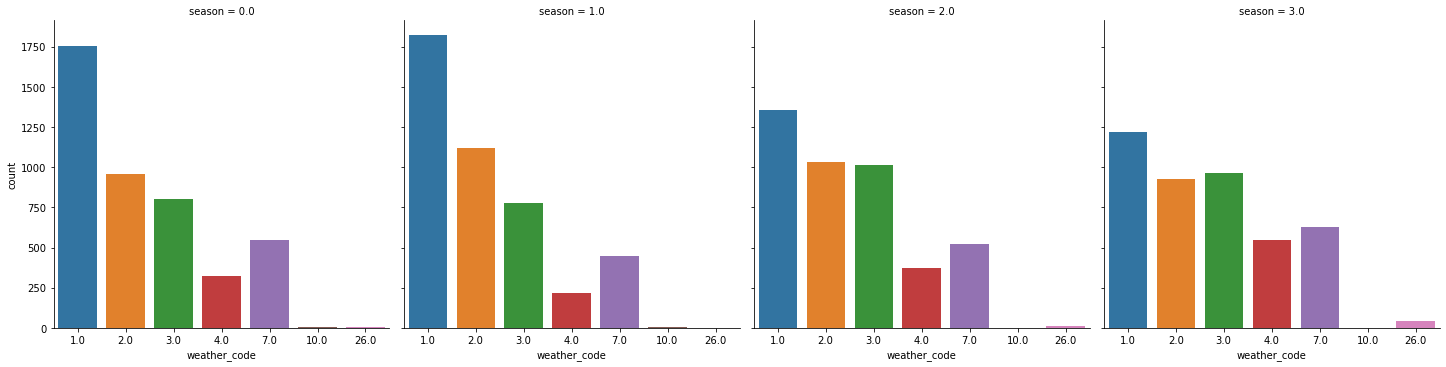

In [18]:
# with catplot

plt.figure(figsize=(6,4))
sns.catplot(x = "weather_code", col = "season", col_wrap = 4, data = df, kind="count");

## Preprocessing
Since the data is time series, we will take first 90% data as training and last 10% as test data

In [19]:
## taking 90% of data to train and 10% of data to test
train_size= int(len(df)*0.90)
test_size= len(df)-train_size

train,test= df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(15672, 13) (1742, 13)


In [20]:
#We’ll scale some of the features we’re using for our modeling
from sklearn.preprocessing import RobustScaler  #Many outliners exist, so using robustscaler
rs= RobustScaler()  #Many outliners exist, so using robustscaler

## Scale the all of the data from columns ['t1', 't2', 'hum', 'wind_speed']
train_cont= train[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
test_cont= test[['t1', 't2', 'hum', 'wind_speed']].to_numpy()

train.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=rs.fit_transform(train_cont)
test.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=rs.transform(test_cont)


C:\Users\Rohit Kumar (Prince)\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Rohit Kumar (Prince)\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [21]:
#Scale the all of the data from columns ['cnt']
train['cnt']=rs.fit_transform(train[['cnt']])
test['cnt']=rs.transform(test[['cnt']])


<ipython-input-21-bb3fbe5dcbff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt']=rs.fit_transform(train[['cnt']])
<ipython-input-21-bb3fbe5dcbff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cnt']=rs.transform(test[['cnt']])


In [22]:
train.to_numpy()
test.to_numpy()

array([[-0.37052342, -0.625     , -0.57142857, ...,  6.        ,
        23.        , 10.        ],
       [-0.07782369, -0.4375    , -0.47619048, ...,  6.        ,
        23.        , 10.        ],
       [ 0.34573003, -0.3125    , -0.33333333, ...,  6.        ,
        23.        , 10.        ],
       ...,
       [-0.35812672, -0.9375    , -1.0952381 , ...,  1.        ,
         3.        ,  1.        ],
       [-0.43595041, -0.9375    , -1.0952381 , ...,  1.        ,
         3.        ,  1.        ],
       [-0.49449036, -1.        , -1.14285714, ...,  1.        ,
         3.        ,  1.        ]])

In [23]:
#To prepare the sequences, we’re going to reuse the same create_dataset() function:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [24]:
#Each sequence is going to contain 10 data points from the history:
time_steps = 24
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)
print(X_train.shape, y_train.shape)

(15648, 24, 13) (15648,)


In [25]:
# [samples, time_steps, n_features]
# Using all 12 columns of data (take out the bike sharing amount column) to make prediction
print('Train data size:')
print(X_train.shape, y_train.shape)
print('Test data size:')
print(X_test.shape, y_test.shape)

Train data size:
(15648, 24, 13) (15648,)
Test data size:
(1718, 24, 13) (1718,)


## Building Model
Let’s start with a simple model and see how it goes. One layer of Bidirectional LSTM with a Dropout layer:

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

model= keras.Sequential()
# Adding Bidirectional and inside Bidirectional LSTM
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))
# Adding dropout 
model.add(keras.layers.Dropout(rate=0.2))
# Adding output layer
model.add(keras.layers.Dense(units=1))

#Compile the model
model.compile(loss='mse',optimizer='adam')



In [27]:
# Fitting the model
#Remember to NOT shuffle the data when training:
history=model.fit(X_train,y_train,epochs=30,shuffle=False,validation_split=0.1,batch_size=32)

Epoch 1/30
441/441 [==============================] - 28s 47ms/step - loss: 0.2857 - val_loss: 0.1575
Epoch 2/30
441/441 [==============================] - 18s 40ms/step - loss: 0.0982 - val_loss: 0.0605
Epoch 3/30
441/441 [==============================] - 16s 36ms/step - loss: 0.0589 - val_loss: 0.0476
Epoch 4/30
441/441 [==============================] - 14s 32ms/step - loss: 0.0438 - val_loss: 0.0411
Epoch 5/30
441/441 [==============================] - 14s 33ms/step - loss: 0.0353 - val_loss: 0.0393
Epoch 6/30
441/441 [==============================] - 14s 32ms/step - loss: 0.0353 - val_loss: 0.0387
Epoch 7/30
441/441 [==============================] - 14s 32ms/step - loss: 0.0285 - val_loss: 0.0301
Epoch 8/30
441/441 [==============================] - 14s 31ms/step - loss: 0.0257 - val_loss: 0.0350
Epoch 9/30
441/441 [==============================] - 13s 31ms/step - loss: 0.0236 - val_loss: 0.0301
Epoch 10/30
441/441 [==============================] - 14s 33ms/step - loss: 0.023

In [28]:
y_pred= model.predict(X_test)


In [29]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
r2 = r2_score(y_test, y_pred)
r2

0.9360974591077026

## Evaluating The Model

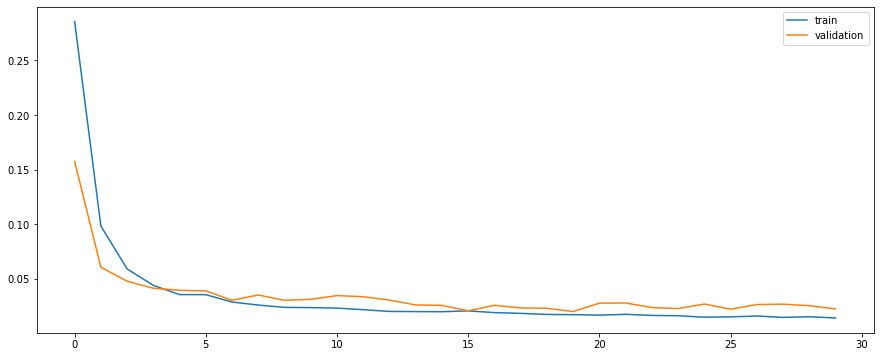

In [30]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [33]:
# Removing the transformation
y_test_inv = rs.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = rs.inverse_transform(y_pred) 

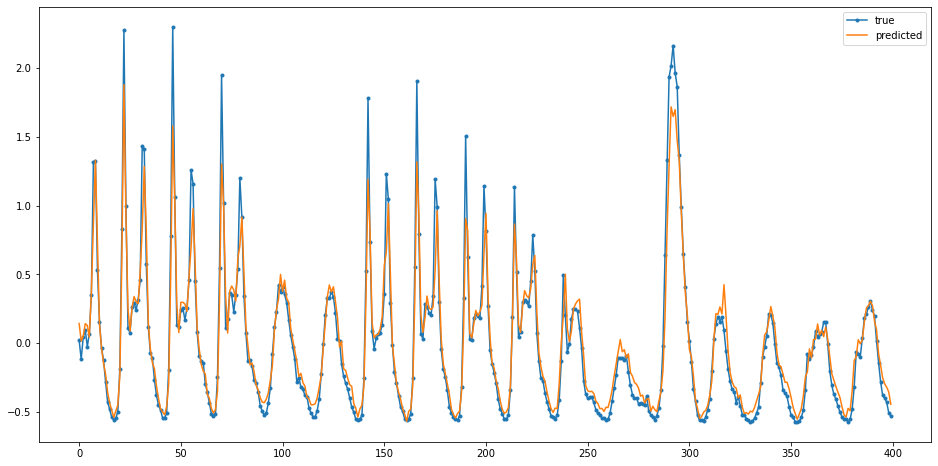

In [35]:
#Pcik some values to zoom in
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1600], marker='.',label='true')
plt.plot(y_pred[1200:1600], label='predicted')
plt.legend()

**Please keep in mind that our model can only predict one point in the future. Having said that, it is performing wonderfully. Our model does a fair job of predicting (understanding) the overall pattern, even though it can't really capture the extreme values.**

## Conclusion

We simply preprocessed a real dataset and used it to forecast bike-sharing demand. We trained the model using subsequences from the original dataset using a Bidirectional LSTM model. We even obtained some great results.

